## GHP Construction with Duration Matching

In [3]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
erk.bond_cash_flows(3, 100, 0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [6]:
erk.bond_price(20, 1000, 0.05, 2, .04)  # 20y bond, 1000 FV, coupon rate=5%, 2cpn/year, discount rate=4%

# Naturally, selling @ Premium, coupon rate > mkt interest rate

1136.7773962036904

In [7]:
erk.bond_price(20, 1000, 0.05, 2, .05)  # Coupon rate = market interest  # Par

1000.0000000000025

In [8]:
erk.bond_price(20, 1000, 0.05, 2, .07)  # Coupon rate < market interest # Discount

786.4492766270262

In [9]:
rates = np.linspace(0.01, 0.10, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [10]:
# List comprehension

prices = [erk.bond_price(10,1000,0.05,2,rate) for rate in rates]
prices

[1379.7483829333994,
 1326.7629283179222,
 1276.1632981372743,
 1227.833537616068,
 1181.6636507727874,
 1137.5492793724407,
 1095.3913999300185,
 1055.0960377089514,
 1016.5739967228162,
 979.7406048086302,
 944.5154728963503,
 910.8222676519945,
 878.5884967212595,
 847.74530584692,
 818.2272871767957,
 789.9722981198867,
 762.9212901465676,
 737.0181469646424,
 712.2095315367839,
 688.4447414365]

<AxesSubplot:title={'center':'Price of 10y bond with different interest rates'}>

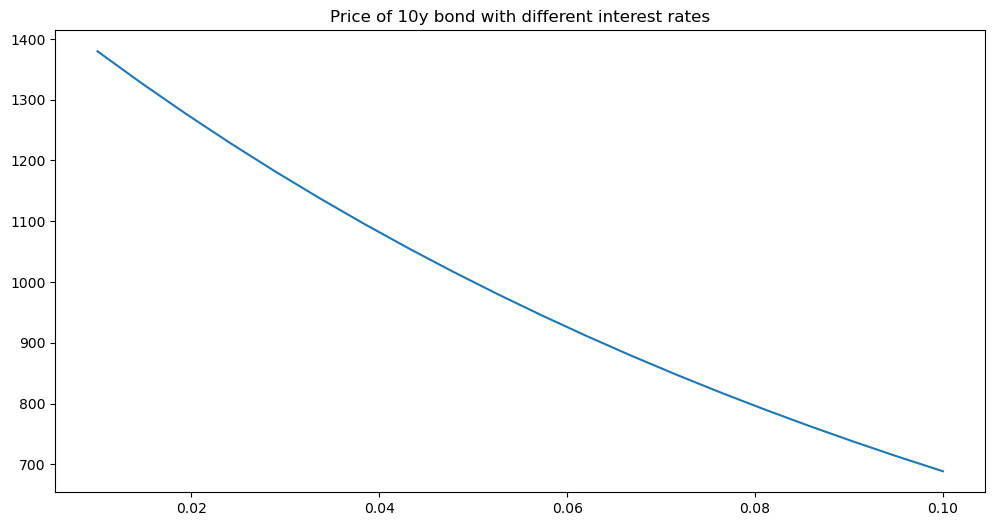

In [12]:
pd.DataFrame(data=prices, index=rates).plot(title= "Price of 10y bond with different interest rates", legend=False, figsize=(12,6))

In [14]:
cf = erk.bond_cash_flows(3, 1000, .06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [15]:
# weighting pmts by present value of the cash flows

discounts = erk.discount(cf.index, 0.06/2)
discounts

Float64Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531596,
              0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
             dtype='float64')

In [17]:
discounted_cf = discounts*cf
discounted_cf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [18]:
weights = discounted_cf/discounted_cf.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [20]:
cf.index*weights

1    0.029126
2    0.056556
3    0.082363
4    0.106618
5    0.129391
6    5.175653
dtype: float64

In [21]:
(cf.index*weights).sum()

5.579707187194534

In [24]:
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, 0.06, 2), .06/2)

5.579707187194534

## Duration Matching

In [25]:
liabilities = pd.Series(data=[100000, 100000], index=[10,12])
erk.macaulay_duration(liabilities, 0.04) # building a port that has the same duration as the liabilities

10.960799385088393

In [26]:
# md_10/20 = macaulay duration of a 10y/20y bond
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, .05, 1), .04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, .05, 1), .04)
md_10, md_20

(8.190898824083233, 13.544718122145921)

In our case, the fraction inthe short duration asset $w_s$ should be such that:

$$ w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96 $$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l - d_t}{d_l - d_s} $$

In [29]:
short_bond = erk.bond_cash_flows(10, 1000, .05, 1)
long_bond = erk.bond_cash_flows(20, 1000, .05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, 0.04)
w_s

# THis means you must put 48.26% of assets into short bond, and 1-w_s into the long bond

0.48263092069478974

In [31]:
p_short = erk.bond_price(10,1000,.05,1,.04)
p_long = erk.bond_price(20,1000,.05,1,.04)
a_0 = 130000 #amount of cash available
port_flows = pd.concat([a_0*w_s*short_bond/p_short,a_0*(1-w_s)*long_bond/p_long])
erk.macaulay_duration(port_flows, 0.04)

10.960799385088393

In [33]:
# Compute funding ratio

current_fr = erk.funding_ratio(port_flows, liabilities, .04)
current_fr

0.9998760012192478

<AxesSubplot:title={'center':'Funding Ratios with Changes in Interest Rates'}>

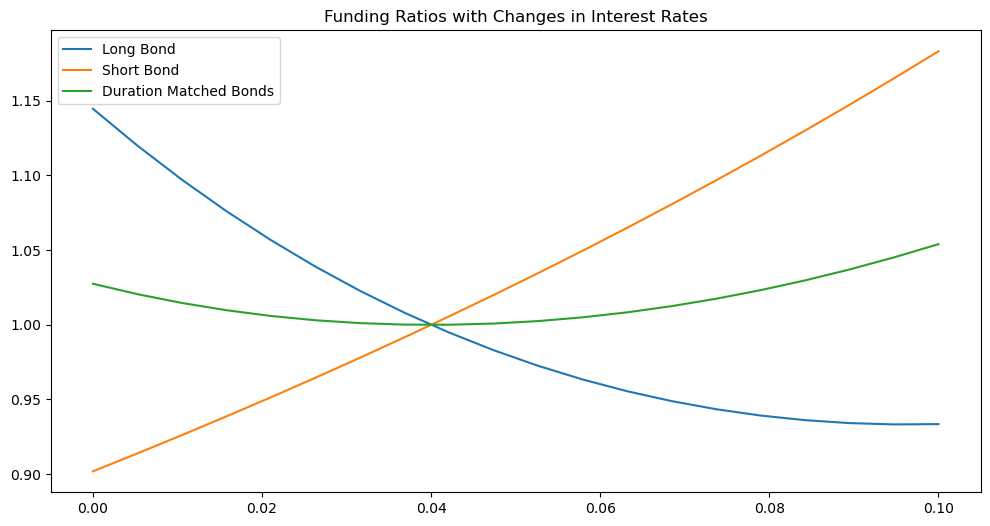

In [37]:
rates = np.linspace(0, .1, 20)
lb_assets = a_0*long_bond/p_long
sb_assets = a_0*short_bond/p_short
fr_change = pd.DataFrame({
    "Long Bond": [erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    "Short Bond": [erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    "Duration Matched Bonds": [erk.funding_ratio(port_flows, liabilities, r) for r in rates]
}, index=rates)

fr_change.plot(title="Funding Ratios with Changes in Interest Rates", figsize=(12,6))